In [107]:
from datetime import datetime
import pandas as pd
import os
import dateutil.parser as date_parser
import matplotlib.pyplot as plt
from typing import Any
import seaborn as sns
import numpy as np
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, ARIMA
from statsforecast.arima import arima_string
import itertools
from pyod.models.knn import KNN
from sklearn.preprocessing import StandardScaler

plt.style.use('ggplot')

## Load timeseries ticker data
### There are 3 tickers analysis is based on:
- S&P 500
- VIX - Volatility index
- US Treasury bonds
- DJIA - Dow Jones Industrial Average

The analysis period is from 2000 to 2024

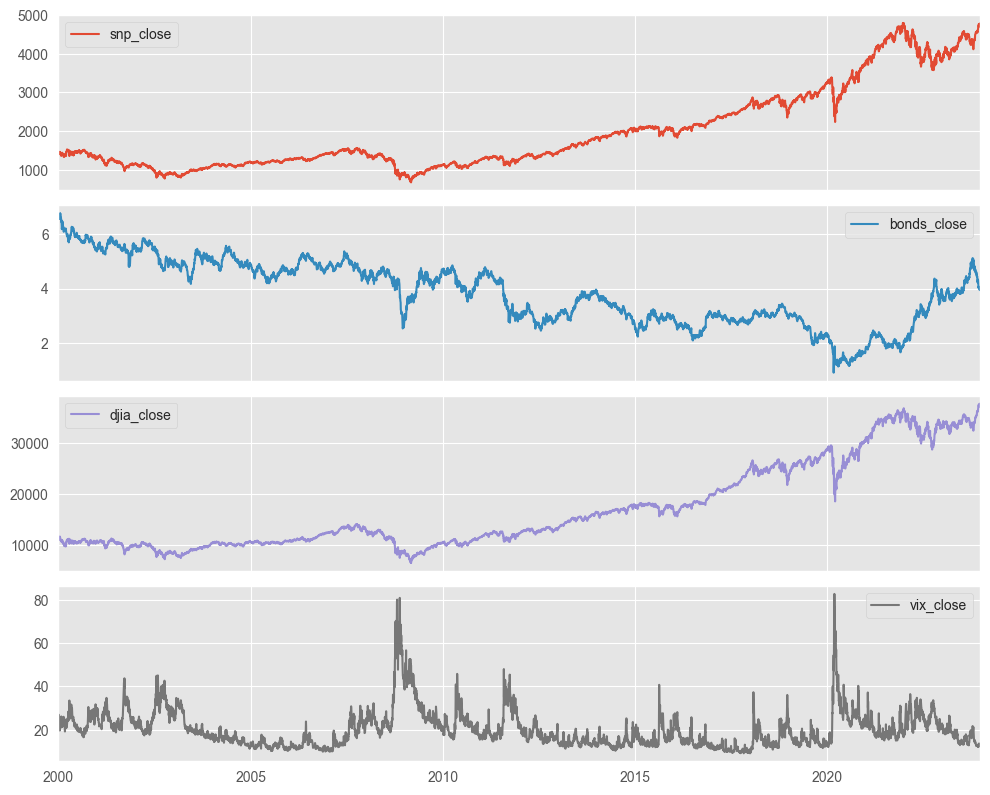

In [108]:
start_date = None
end_date = None

snp_data = pd.read_csv('assets/snp_data_clean.csv', index_col=0, parse_dates=True).add_prefix('snp_')[
           start_date:end_date]
bonds_data = pd.read_csv('assets/bonds_data_clean.csv', index_col=0, parse_dates=True).add_prefix('bonds_')[
             start_date:end_date]
djia_data = pd.read_csv('assets/djia_data_clean.csv', index_col=0, parse_dates=True).add_prefix('djia_')[
            start_date:end_date]
vix_data = pd.read_csv('assets/vix_data_clean.csv', index_col=0, parse_dates=True).add_prefix('vix_')[
           start_date:end_date]

merged_data = pd.concat(
    [snp_data['snp_close'], bonds_data['bonds_close'], djia_data['djia_close'], vix_data['vix_close']], axis=1)

merged_data.plot(subplots=True, figsize=(10, 8))
plt.tight_layout()
plt.show()

### Scale data

In [109]:
anom_start_date = '2021-01-01'
anom_end_date = '2022-01-01'

boundary_data = merged_data[anom_start_date:anom_end_date]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(boundary_data)
scaled_data = pd.DataFrame(scaled_data, columns=boundary_data.columns, index=boundary_data.index)

print(scaled_data.head())

            snp_close  bonds_close  djia_close  vix_close
2021-01-01  -1.875560    -2.091072   -2.220411   1.442920
2021-01-04  -1.971240    -2.065049   -2.337645   2.028807
2021-01-05  -1.880739    -1.810030   -2.234866   1.576202
2021-01-06  -1.807262    -1.206311   -1.966562   1.501231
2021-01-07  -1.615108    -1.081404   -1.836804   0.751517


### Anomaly detection and removal

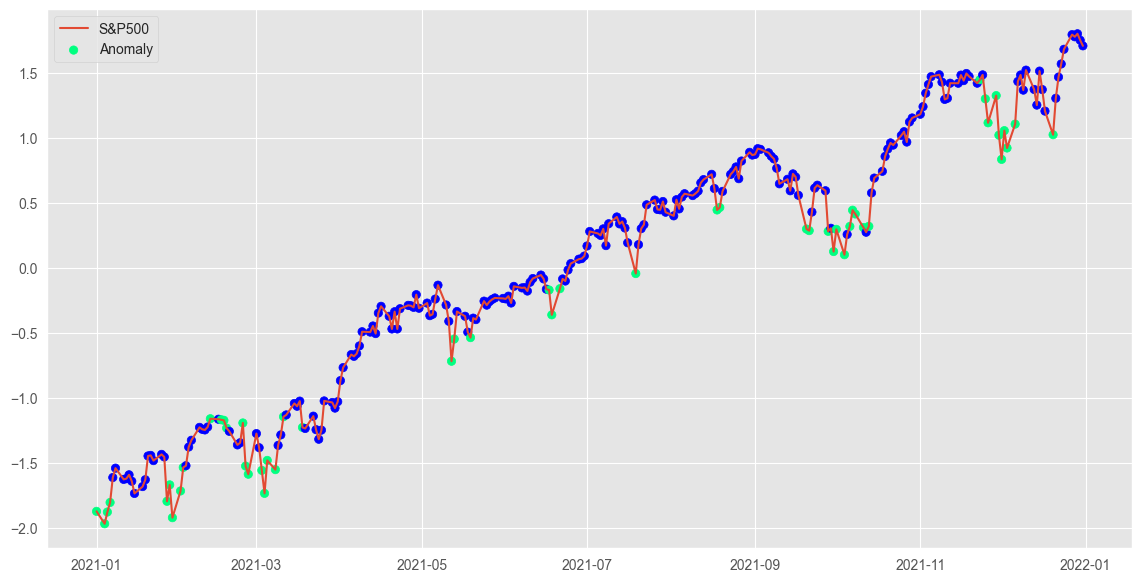

In [110]:
clf = KNN(contamination=0.2)

clf.fit(scaled_data)

y_pred = clf.labels_  # 0 for inliers, 1 for outliers
outlier_scores = clf.decision_scores_

scaled_data['anomaly'] = y_pred



plt.figure(figsize=(14, 7))
plt.plot(scaled_data.index, scaled_data['snp_close'], label='S&P500')
plt.scatter(scaled_data.index, scaled_data['snp_close'], c=y_pred, cmap='winter', label='Anomaly')
plt.legend()
plt.show()

In [ ]:
cleaned_data = scaled_data[scaled_data['anomaly'] == 0].drop(columns=['anomaly'])